# Variance-level plots

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
ls = [6, 7, 8, 9]

In [5]:
from gpuocean.utils import DoubleJetCase

args_list = []
init_list = []

for l in ls:
    doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=2**l, nx=2**(l+1))
    doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

    args_list.append(doubleJetCase_args)
    init_list.append(doubleJetCase_init)

### Set Work (theoretical)

In [8]:
works = [1/(8**3), 1/(8**2), 1/(8), 1]
diff_works = [1/(8**2), 1/(8), 1]

In [9]:
works, diff_works

([0.001953125, 0.015625, 0.125, 1], [0.015625, 0.125, 1])

### Set variances (practical)

In [10]:
source_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/VarianceLevelsDA/2023-10-27T17_43_20mean"

In [15]:
vars = np.load(source_path+"/vars_"+str(10*24*3600)+".npy")
diff_vars = np.load(source_path+"/diff_vars_"+str(10*24*3600)+".npy")

## Ensembles with equal error $\tau$

In [79]:
def speedup(tau, vars, diff_vars):

    allwork = np.sqrt(vars[0] * works[0])
    for k_idx in range(1, len(ls)):
        allwork += np.sqrt(diff_vars[k_idx-1] * diff_works[k_idx-1])

    ML_Ne = np.zeros(len(ls))
    ML_Ne[0] = 1/(tau**2)*np.sqrt(vars[0]/works[0]) * allwork
    for l_idx in range(1, len(ls)):
        ML_Ne[l_idx] = 1/(tau**2)*np.sqrt(diff_vars[l_idx-1]/diff_works[l_idx-1]) * allwork

    MLwork = ML_Ne[0]*works[0]
    for l_idx in range(1, len(ML_Ne)):
        MLwork += ML_Ne[l_idx]*diff_works[l_idx-1]

    SLwork = vars[-1]/(tau**2) * works[-1]

    su = SLwork/MLwork

    print("tau = ", tau, 
            " SL_Ne = ", (vars[-1]/(tau**2)).astype(int),
            " ML_Ne = ", ML_Ne.astype(int), 
            " speedup = ", su, 
            " ML_work = ", MLwork)

    return su


tau =  500  SL_Ne =  5776  ML_Ne =  [31726 15461  5245  1426]  speedup =  2.4213155212719664  ML_work =  2385.6469416119453
tau =  600  SL_Ne =  4011  ML_Ne =  [22032 10737  3642   990]  speedup =  2.421315521271967  ML_work =  1656.6992650082952
tau =  700  SL_Ne =  2947  ML_Ne =  [16186  7888  2676   727]  speedup =  2.421315521271967  ML_work =  1217.16680694487
tau =  800  SL_Ne =  2256  ML_Ne =  [12393  6039  2049   557]  speedup =  2.4213155212719664  ML_work =  931.8933365671661
tau =  900  SL_Ne =  1782  ML_Ne =  [9792 4772 1618  440]  speedup =  2.4213155212719664  ML_work =  736.3107844481312
tau =  1000  SL_Ne =  1444  ML_Ne =  [7931 3865 1311  356]  speedup =  2.4213155212719664  ML_work =  596.4117354029863
tau =  1100  SL_Ne =  1193  ML_Ne =  [6554 3194 1083  294]  speedup =  2.421315521271967  ML_work =  492.90226066362504
tau =  1200  SL_Ne =  1002  ML_Ne =  [5508 2684  910  247]  speedup =  2.421315521271967  ML_work =  414.1748162520738
tau =  1300  SL_Ne =  854  ML_N

Text(0, 0.5, 'speedup')

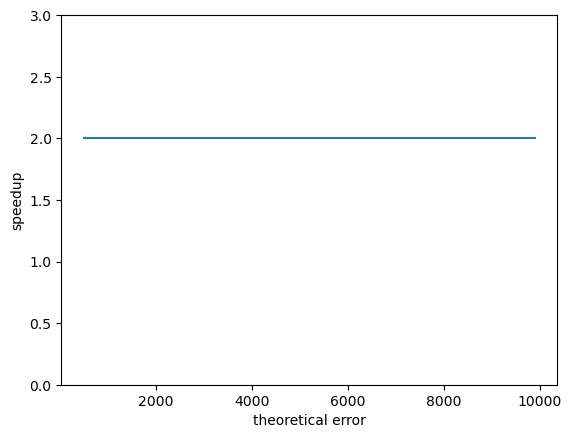

In [86]:
# var_idx = 0 # eta
var_idx = 1 # hu
# var_idx = 2 # hv

if var_idx == 0:
    taus = np.arange(5, 50, 2) # for eta    
else:
    taus = np.arange(500, 10000, 100) # for hu, hv 

sus = np.zeros_like(taus)
for t in range(len(taus)):
    sus[t] = speedup(taus[t], vars[:,var_idx], diff_vars[:,var_idx])

plt.plot(taus, sus)
plt.ylim((0,3))
plt.xlabel("theoretical error")
plt.ylabel("speedup")